<a href="https://colab.research.google.com/github/Ibraheem101/mlops/blob/main/foundations/Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word embeddings

The motivation for word embeddings in natural language processing (NLP) arises from the need to represent words in a numerical format that captures their semantic and syntactic similarities. Traditional approaches in NLP, such as one-hot encoding or bag-of-words representations, treat words as discrete symbols with no inherent meaning or relationship between them. However, words do possess rich contextual information and often exhibit semantic connections based on their usage in text.

Word embeddings aim to address this limitation by representing words as dense vectors in a continuous vector space. The key motivation behind word embeddings is to capture the meaning and relationships between words based on their distributional properties in a given corpus. The underlying idea is that words that occur in similar contexts tend to have similar meanings.

By learning word embeddings, NLP models can benefit from several advantages:

* Semantic Similarity: Word embeddings capture semantic relationships between words. Words with similar meanings or concepts are represented by vectors that are closer to each other in the embedding space. For example, the vectors for "king" and "queen" would be closer to each other than to the vector for "apple."

* Syntactic Regularities: Word embeddings can capture syntactic regularities and analogies between words. For example, the vector difference between "man" and "woman" might be similar to the vector difference between "king" and "queen," capturing the analogy between gendered terms.

* Dimensionality Reduction: Word embeddings provide a lower-dimensional representation of words compared to one-hot encoding or bag-of-words models. This reduces the dimensionality of the input space and helps mitigate the curse of dimensionality in NLP tasks.

* Generalization: Word embeddings can generalize to unseen words or rare words by leveraging the similarities learned from the training data. Models can infer similarities and relationships for words not explicitly encountered during training, which is valuable for handling out-of-vocabulary words.

* Efficiency: Word embeddings reduce the computational complexity of NLP models by representing words as continuous vectors. This enables efficient processing and computation compared to sparse representations.

In [1]:
import os
import re
import json
import math
import nltk
import torch
import gensim
import random
import urllib
import itertools
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

We can learn embeddings by creating our models in PyTorch but first, we're going to use a library that specializes in embeddings and topic modeling called Gensim.

In [2]:
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
seed = 1234

In [4]:
def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU

In [5]:
set_seeds(seed = seed)

### Load data

In [6]:
# Split text into sentences
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
book = urllib.request.urlopen(url="https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/harrypotter.txt")
sentences = tokenizer.tokenize(str(book.read()))
print (f"{len(sentences)} sentences")

12449 sentences


In [7]:
sentences[26]

'He seemed unable to prevent himself from glancing upward every minute or so.\\r\\n"Yaxley.'

In [8]:
def preprocess(text):

    # lowercasing
    text = text.lower()

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
    text = re.sub("[^A-Za-z0-9]+", " ", text) # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()

    # Separate into word tokens
    text = text.split(" ")

    return text

In [9]:
print(sentences[27])
sentences = [preprocess(sentence) for sentence in sentences]
print(sentences[27])

Snape," said a high, clear voice from the head of the table.
['snape', 'said', 'a', 'high', 'clear', 'voice', 'from', 'the', 'head', 'of', 'the', 'table']


<details>
    <summary>Approaches to learning embeddings</summary>

1. Continuous Bag of Words (CBOW):
In CBOW, the objective is to predict the target word based on the context words surrounding it.
The model takes a fixed-size context window of words as input and tries to predict the target word in the middle.
The context words are typically represented as one-hot vectors or pre-trained word embeddings.
The model is trained using a neural network, where the context words are passed through an embedding layer, followed by a hidden layer, and finally a softmax output layer.
The embedding layer learns the dense representations (embeddings) of the context words, which are updated during training to improve the prediction accuracy.
The learned embeddings capture the semantic and syntactic relationships between words based on their co-occurrence patterns.

2. Skip-gram:
In skip-gram, the objective is to predict the context words given a target word.
The model takes a target word as input and tries to predict the surrounding context words.
Similar to CBOW, the context words can be represented as one-hot vectors or pre-trained embeddings.
The model architecture consists of an embedding layer followed by a hidden layer and a softmax output layer.
During training, the model adjusts the embeddings to maximize the probability of predicting the correct context words.
The skip-gram approach is useful when we want to focus on rare words and capture more fine-grained relationships between words.

3. Language Modeling (LM):
Language modeling involves predicting the next word in a sequence of words given the previous words.
The objective of LM is to learn the probability distribution of words in a language.
The model takes a sequence of words as input and tries to predict the next word.
It typically uses recurrent neural network (RNN) architectures, such as LSTM or GRU, to capture the sequential dependencies between words.
The embeddings are learned as part of the training process, where the model updates the embeddings based on the predicted probabilities.
Language models can be trained on large text corpora and can capture the contextual relationships between words.
These approaches learn word embeddings by training neural network models on large amounts of text data. By considering the context of words, they capture the semantic and syntactic relationships, allowing words with similar meanings or usage to have similar embeddings. The resulting embeddings can then be used in various NLP tasks such as sentiment analysis, machine translation, and text generation.
</details>

### Word2vec
[Understand Word2vec](https://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)

In [10]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

In [11]:
embedding_dim = 100
window = 5
min_count = 3 # Ignores all words with total frequency lower than this
skip_gram = 1 # 0 = CBOW
negative_sampling = 20

In [12]:
# Super fast because of optimized C code under the hood
w2v = Word2Vec(
    sentences=sentences, vector_size=embedding_dim,
    window=window, min_count=min_count,
    sg=skip_gram, negative=negative_sampling)
print(w2v)

Word2Vec<vocab=4937, vector_size=100, alpha=0.025>


In [13]:
# Vector for each word
w2v.wv.get_vector("harry"), len(w2v.wv.get_vector("harry")) #embedding vector e

(array([-8.36122483e-02,  3.72593522e-01,  7.01045478e-03,  8.98950547e-02,
         1.65470481e-01, -3.51022661e-01,  2.50414550e-01,  3.85206997e-01,
        -7.50519097e-01, -2.80024737e-01,  3.34674902e-02, -3.67605567e-01,
        -1.98151469e-01,  1.24584325e-02, -6.27987012e-02, -6.03984036e-02,
         4.48846102e-01, -2.03901887e-01, -5.90737045e-01, -2.80682683e-01,
        -1.23700075e-01,  1.85041964e-01,  1.83086127e-01, -2.38956332e-01,
         1.99852169e-01, -9.25628617e-02, -4.75979924e-01,  3.17589611e-01,
        -1.11513078e-01,  2.78555248e-02,  2.56654620e-01,  1.25676230e-01,
        -2.87806004e-01,  2.70128429e-01,  3.36311273e-02,  2.01222792e-01,
        -8.24235305e-02,  6.51640147e-02,  2.08387673e-01, -1.66490674e-01,
        -1.41929612e-01, -4.12383407e-01,  2.02513486e-02,  1.38338236e-02,
         1.29887223e-01, -1.80447340e-01, -2.18640149e-01, -2.97859479e-02,
        -1.94274127e-01, -8.74161497e-02,  4.31444317e-01, -2.20782980e-01,
         2.1

In [14]:
# Get nearest neighbors (excluding itself)
w2v.wv.most_similar(positive="man", topn=5)

[('wizard', 0.9163126945495605),
 ('witch', 0.8928037881851196),
 ('woman', 0.8813951015472412),
 ('odd', 0.8680001497268677),
 ('familiar', 0.8580108880996704)]

In [15]:
# Saving and loading
w2v.wv.save_word2vec_format("model.bin", binary=True)
w2v = KeyedVectors.load_word2vec_format("model.bin", binary=True)

### FastText
When a word doesn't exist in our vocabulary, there are a few approaches we can take to handle it:

UNK Token:

One common approach is to assign a special token, often called the "UNK" token, to represent out-of-vocabulary words.
During training, if a word is encountered that is not present in the vocabulary, it is replaced with the UNK token.
The UNK token allows the model to learn a representation for unknown words and treat them similarly during inference.
FastText:

FastText, as you mentioned, uses character-level n-grams to embed words. This technique enables it to handle rare words, misspelled words, and even words that are not present in the training corpus.
By breaking down words into smaller subword units (character n-grams), FastText can still capture some information about the meaning of the word, even if it is unseen.
When encountering an out-of-vocabulary word, FastText can leverage the character n-gram information to generate an embedding for the word based on the embeddings of its subword units.
This approach can be particularly useful in scenarios where the vocabulary is limited or when dealing with morphologically rich languages.

In [16]:
from gensim.models import FastText

In [17]:
# Super fast because of optimized C code under the hood
ft = FastText(sentences=sentences, vector_size=embedding_dim,
              window=window, min_count=min_count,
              sg=skip_gram, negative=negative_sampling)
print(ft)

FastText<vocab=4937, vector_size=100, alpha=0.025>


In [18]:
# This word doesn't exist so the word2vec model will error out
try:
    w2v.most_similar(positive="scarring", topn=5)
except KeyError:
    print("The word doesn't exist in the vocabulary")

The word doesn't exist in the vocabulary


In [19]:
# FastText will use n-grams to embed an OOV word
ft.wv.most_similar(positive="scarring", topn=5)

[('quivering', 0.9931723475456238),
 ('shuddering', 0.9916975498199463),
 ('dabbing', 0.9912965297698975),
 ('squeezing', 0.9912393689155579),
 ('wriggling', 0.9908320307731628)]

In [20]:
# Save and loading
ft.wv.save("model.bin")
ft = KeyedVectors.load("model.bin")

In [21]:
ft.most_similar(positive="scarring", topn=5)

[('quivering', 0.9931723475456238),
 ('shuddering', 0.9916975498199463),
 ('dabbing', 0.9912965297698975),
 ('squeezing', 0.9912393689155579),
 ('wriggling', 0.9908320307731628)]

### GloVe
GloVe (Global Vectors for Word Representation) is an unsupervised learning algorithm for generating word embeddings. It constructs a co-occurrence matrix from a large corpus of text, initializes word vectors, defines an objective function based on co-occurrence statistics, and optimizes the word vectors to capture semantic relationships. The resulting word embeddings are dense vector representations that capture similarities between words. GloVe leverages global statistical information and performs well in various NLP tasks.

In [22]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from sklearn.decomposition import PCA
from gensim.scripts.glove2word2vec import glove2word2vec

In [62]:
def plot_embeddings(words, embeddings, pca_results):
    for word in words:
        index = embeddings.index_to_key.index(word)
        plt.scatter(pca_results[index, 0], pca_results[index, 1])
        plt.annotate(word, xy=(pca_results[index, 0], pca_results[index, 1]))
    plt.show()

<details>
    <summary>Explanation</summary>
    
The function plot_embeddings takes three arguments: words, embeddings, and pca_results. Here's a breakdown of what the function does:
It iterates over each word in the words list.
For each word, it retrieves the corresponding index in the embeddings object using embeddings.index2word.index(word).
It plots a scatter point on a 2D plot using the x and y coordinates from pca_results.
It annotates the scatter point with the word using plt.annotate.
Finally, it displays the plot using plt.show().
The purpose of this function is to visualize word embeddings in a 2D space using PCA (Principal Component Analysis) results. It plots the words as scatter points and annotates each point with its corresponding word. The embeddings object represents a collection of word embeddings, and pca_results contains the PCA-transformed coordinates for each embedding. The words list specifies which words to visualize.
</details>

### Load

In [63]:
cd content

[Errno 2] No such file or directory: 'content'
/content


In [64]:
cp kaggle.json ~/.kaggle/

In [65]:
! chmod 600 /root/.kaggle/kaggle.json

In [66]:
! kaggle datasets download anindya2906/glove6b/download?datasetVersionNumber=1

glove6b.zip: Skipping, found more recently modified local copy (use --force to force download)


In [67]:
# Unzip the file (may take ~3-5 minutes)
# Specify the path to the zip file
zip_path = "../content/glove6b.zip"

# Open the zip file
with ZipFile(zip_path, 'r') as zip_ref:
    # Extract all the contents of the zip file
    zip_ref.extractall("../content/")

In [68]:
# Write embeddings to file
embeddings_file = "glove.6B.{0}d.txt".format(embedding_dim)

In [69]:
# Preview of the GloVe embeddings file
with open(embeddings_file, "r") as fp:
    line = next(fp)
    values = line.split()
    word = values[0]
    embedding = np.asarray(values[1:], dtype='float32')
    print (f"word: {word}")
    print (f"embedding:\n{embedding}")
    print (f"embedding dim: {len(embedding)}")

word: the
embedding:
[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459


In [70]:
# Save GloVe embeddings to local directory in word2vec format
word2vec_output_file = "{0}.word2vec".format(embeddings_file)
glove2word2vec(embeddings_file, word2vec_output_file)

<ipython-input-70-b004bd08d681>:3: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(embeddings_file, word2vec_output_file)


(400000, 100)

In [71]:
# Load embeddings (may take a minute)
glove = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [72]:
# (king - man) + woman = ?
# king - man = ? -  woman
glove.most_similar(positive=["woman", "king"], negative=["man"], topn=5)

[('queen', 0.7698540687561035),
 ('monarch', 0.6843381524085999),
 ('throne', 0.6755736470222473),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534157752991)]

In [73]:
glove.most_similar(positive=["woman", "boy"], negative=["man"], topn=5)

[('girl', 0.9095936417579651),
 ('mother', 0.7666921019554138),
 ('child', 0.7420270442962646),
 ('pregnant', 0.7282999157905579),
 ('girls', 0.7268646359443665)]

In [74]:
# Get nearest neighbors (excluding itself)
glove.most_similar(positive="hey", topn=5)

[('yeah', 0.8196864128112793),
 ('gonna', 0.7466485500335693),
 ('ok', 0.74472576379776),
 ('hello', 0.7171452045440674),
 ('`', 0.7170859575271606)]

In [75]:
# Reduce dimensionality for plotting
X = np.array([glove.get_vector(word) for word in glove.index_to_key])
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X)

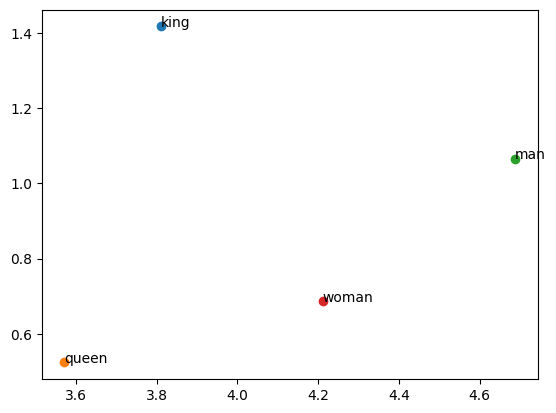

In [76]:
# Visualize
plot_embeddings(
    words=["king", "queen", "man", "woman"], embeddings=glove,
    pca_results=pca_results)


In [77]:
# Bias in embeddings
glove.most_similar(positive=["woman", "doctor"], negative=["man"], topn=5)

[('nurse', 0.7735227942466736),
 ('physician', 0.7189430594444275),
 ('doctors', 0.6824328303337097),
 ('patient', 0.6750683188438416),
 ('dentist', 0.6726033091545105)]

In [78]:
# Set device
cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")
torch.set_default_tensor_type("torch.FloatTensor")
if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
print (device)

cpu
